# Question 1

## 1.Text preprocessing

**Read file and store documents in dataframe**

In [1]:
## read the file (each line of the text file is one document)
text <- readLines('./Task2A.txt')

# strip label and document
docs <- strsplit(text, '\t')

# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))
                         
# number of document
N <- length(labels)
                         
# store the unlabeled texts    
uid <- paste0("doc_", formatC(1:N, width = 4, format = "d", flag = "0"))
docs <- data.frame(doc_id = uid, text = unlist(lapply(docs, function(x) x[2])))

**Feature extraction**

In [2]:
# load Text Mining library
library(tm)

# create a corpus
docs <- DataframeSource(docs)
docs <- Corpus(docs)

# Preprocessing:
docs <- tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
docs <- tm_map(docs, removePunctuation) # remove punctuation
docs <- tm_map(docs, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers) # remove all numbers
docs <- tm_map(docs, stripWhitespace) # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)

## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)

## convert dtm to a matrix
m <- as.matrix(dtm)
rownames(m) <- 1:nrow(m)

Warning message:
"package 'tm' was built under R version 3.5.3"Loading required package: NLP
Warning message:
"package 'NLP' was built under R version 3.5.2"

In [3]:
dim(m)

[1] 2373  129

There are 129 words in the 2373 documents after appling stemming,  removing stop words and punctuation and reducing the sparcity of the document matrix.

## 2. Soft EM
**Initialize parameters**

In [4]:
# Setting the parameters:
K <- 4 # number of cluster
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.001     # termination threshold
word <- dim(m)[2]
doc <- dim(m)[1]

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456) # save the random seed to make the results reproducble

# initialize phi uniformly
Phi.hat <- c(1/K, 1/K, 1/K, 1/K)

# initialize mu randomly, we cannot initiailize mu uniformly 
# because this result in no majority class in the first iteration for hard EM
mu_0 <- matrix(runif(K*word), nrow = K, ncol = word)
mu <- mu_0 / rowSums(mu_0)

rownames(mu) <- 1:K
colnames(mu) <- colnames(m)

# initialize posterior matrix
post <- matrix(, nrow = N, ncol = K)

**Check initialization**

In [5]:
Phi.hat
mu
head(post)
head(m)

[1] 0.25 0.25 0.25 0.25

,actual,also,anyon,anyth,around,avail,believ,bit,call,can,...,space,phone,apr,chip,power,back,design,day,nasa,clipper
1,0.012978813,0.005877740,0.016070860,0.01472810,0.014294274,0.002596359,0.007772764,0.013891403,0.003760590,0.015493588,...,0.0044186612,0.009944374,0.010269877,0.007935486,0.0031213451,0.007307050,0.009960365,0.008972187,0.0001432896,0.011836316
2,0.012115296,0.003188849,0.002694066,0.01416167,0.003176968,0.001296558,0.011262229,0.002668632,0.001914500,0.014013258,...,0.0003576039,0.009322473,0.003062740,0.006495422,0.0061585722,0.004196688,0.002354682,0.000321172,0.0060810764,0.012644749
3,0.005746476,0.007855600,0.011720277,0.01459674,0.004920139,0.001948271,0.012923163,0.007680980,0.012101589,0.010459591,...,0.0048368052,0.006330705,0.003795548,0.011247542,0.0048963153,0.007847436,0.004191632,0.010157155,0.0102891472,0.003704691
4,0.005382414,0.001521107,0.009357290,0.01411891,0.012247589,0.002708968,0.013832693,0.013696138,0.001265043,0.009540254,...,0.0153447178,0.007263597,0.010373982,0.003992341,0.0004332961,0.007049818,0.010864302,0.014963004,0.0103589416,0.007159916


NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


,actual,also,anyon,anyth,around,avail,believ,bit,call,can,...,space,phone,apr,chip,power,back,design,day,nasa,clipper
1,1,2,2,2,1,2,1,2,2,7,...,0,0,0,0,0,0,0,0,0,0
2,1,6,2,3,1,6,3,3,3,9,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,1,2,0,7,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,3,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0


**Run soft EM**

In [6]:
mu.old <- mu

while (!terminate){
    # E step
    # calculate posterior probability
    for (r in 1:doc){ #2373
        # matrix to store z value
        z <- matrix(nrow = 1, ncol=K)
        
        # for every cluster
        for (k in 1:K){

            temp <- matrix(nrow = 1, ncol=dim(m)[2])

            for (c in 1:word){ #129
                # calculate word count times the log of word proportion in the cluster
                temp[1,c] <- m[r,c] * log(mu[k,c])
            }
            # calculate z value
            z[1,k]<- log(Phi.hat[k]) + sum(temp)
        }
        # find max in z value
        max_z <- max(z)
        # scale the z value by the max value
        z <- z - max_z
        # calculate posterior probability
        post[r,] <- exp(z)/sum(exp(z))
    }
    
    # M step
    # calculate Nk
    Nk <- colSums(post)
    # update Phi hat
    Phi.hat <- Nk/N

    # update mu
    for (k in 1:K){
        # initialize denominator
        denom <- 0
        # calculate denominator
        for (c in 1:word){
            denom <- denom + post[,k] %*% m[,c]
        }
        # initialize empty vector to store result
        v <- vector()
        # calculate new mu
        for (c in 1:word){
            v <- append(v, (post[,k] %*% m[,c]) / denom)
        }
        # update mu
        mu[k,]<- v
    }
    # increment epoch counter
    eta <- eta +1
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(mu.old - mu)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    mu.old <- mu
}


In [7]:
Phi.hat

[1] 0.19909003 0.33709353 0.39787053 0.06594592

In [8]:
## perform pca
p.comp <- prcomp(m)  

In [9]:
head(p.comp$x)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129
1,-39.031155,-16.37856933,-8.03884512,-16.3165613,5.52142647,-2.8680020,-17.43717992,-8.5310275,-1.3565290,1.72988914,...,0.1263796,-0.99007945,-0.09669631,0.7808816,0.55029580,0.01530088,0.2971536,1.35112138,0.43763363,0.1430693
2,-53.447214,-21.17393936,-9.44253325,-22.1796052,8.57830460,-6.6800556,-24.71700936,-7.4731352,-3.5834523,1.28705330,...,0.4630843,0.89193530,-0.26705898,0.6992501,-0.05193110,0.33897609,-0.2435168,-0.09328083,-0.19602719,-0.5132949
3,-21.456324,-11.98397933,-3.85909920,-9.5973328,0.67112596,1.7676968,-10.99859428,0.7814324,-1.1922118,3.28280472,...,-0.5455299,0.19342163,0.14130895,-0.5173977,0.42696519,-0.24785473,0.2437735,0.61581168,-0.31789195,0.3098768
4,3.104305,0.63324897,-0.75214328,-0.3451755,0.07357101,-0.3676298,0.24960018,-0.4131416,0.2063431,0.08398423,...,0.4238764,0.05425341,0.35730845,0.1168673,0.04751813,0.12687446,0.1486392,-0.05442925,-0.02759842,-0.2327360
5,2.240195,-0.49441725,0.07298984,1.2797483,0.30838993,0.5834753,-0.49853350,0.6078362,-0.1276464,-0.06954809,...,0.2321288,-0.55042695,-0.04033789,0.1119521,0.04824799,-0.14874986,-0.1899080,0.04840867,0.10201562,0.1099446
6,-4.371924,0.04648693,0.17400258,2.6663947,3.33265226,-3.4303465,0.01756266,2.0899692,2.1473719,-0.48108445,...,0.2582998,-0.06429485,-0.29457647,-0.3933437,0.21819425,-0.27388996,-0.3559755,-1.06073486,-0.29686011,0.2442492


**Visualize result**

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



Saving 6.67 x 6.67 in image


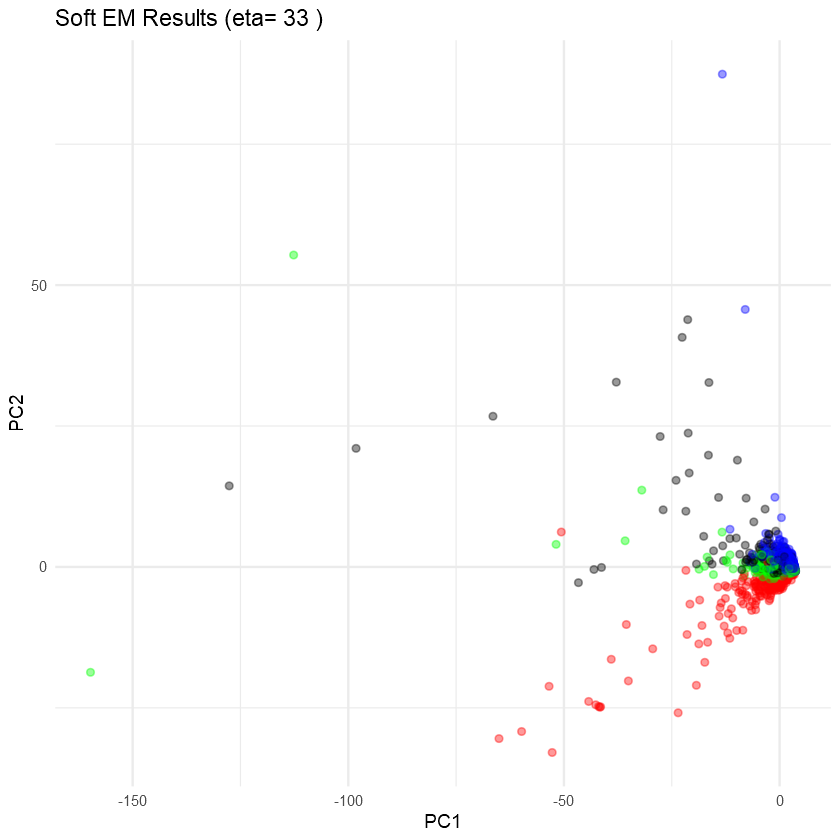

In [10]:
library(ggplot2)

# plot PC1 against PC2
ggplot(data=as.data.frame(p.comp$x), aes(x=PC1, y=PC2)) + 
        geom_point(color=rgb(post), alpha=0.4) +
        ggtitle (paste('Soft EM Results (eta=', eta, ')')) + theme_minimal()

ggsave('Q1_1.jpg')

## 3.Hard EM
**re-initialize the parameters**

In [11]:
# Setting the parameters:
K <- 4 # number of cluster
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.001     # termination threshold
word <- dim(m)[2]
doc <- dim(m)[1]

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

## Ramdom cluster initialization:
set.seed(123456) # save the random seed to make the results reproducble

# initialize phi uniformly
Phi.hat <- c(1/K, 1/K, 1/K, 1/K)

# initialize mu randomly, we cannot initiailize mu uniformly 
# because this result in no majority class in the first iteration for hard EM
mu_0 <- matrix(runif(K*word), nrow = K, ncol = word)
mu <- mu_0 / rowSums(mu_0)

rownames(mu) <- 1:K
colnames(mu) <- colnames(m)

# initialize posterior matrix
post <- matrix(, nrow = N, ncol = K)

**Run hard EM**

The context of hard EM is mostly the same as soft EM, the only difference is after calculating the posterior probability in the E step, we choose the highest probability and set it to 1 and the others to 0.

In [12]:
mu.old <- mu

while (!terminate){
    # E step
    # calculate posterior probability
    for (r in 1:doc){ #2373
        # matrix to store z value
        z <- matrix(nrow = 1, ncol=K)
        
        # for every cluster
        for (k in 1:K){

            temp <- matrix(nrow = 1, ncol=dim(m)[2])

            for (c in 1:word){ #129
                # calculate word count times the log of word proportion in the cluster
                temp[1,c] <- m[r,c] * log(mu[k,c])
            }
            # calculate z value
            z[1,k]<- log(Phi.hat[k]) + sum(temp)
        }
        # find max in z value
        max_z <- max(z)
        # scale the z value by the max value
        z <- z - max_z
        # calculate posterior probability
        post[r,] <- exp(z)/sum(exp(z))
    }
    
    # hard assignments:
    max.prob <- post==apply(post, 1, max) # for each point find the cluster with the maximum (estimated) probability
    post[max.prob] <- 1 # assign each point to the cluster with the highest probability
    post[!max.prob] <- 0 # remove points from clusters with lower probabilites
    
    # M step
    # calculate Nk
    Nk <- colSums(post)
    # update Phi hat
    Phi.hat <- Nk/N

    # update mu
    for (k in 1:K){
        # initialize denominator
        denom <- 0
        # calculate denominator
        for (c in 1:word){
            denom <- denom + post[,k] %*% m[,c]
        }
        # initialize empty vector to store result
        v <- vector()
        # calculate new mu
        for (c in 1:word){
            v <- append(v, (post[,k] %*% m[,c]) / denom)
        }
        # update mu
        mu[k,]<- v
    }
    # increment epoch counter
    eta <- eta +1
    # check the termination criteria
    terminate <- eta > eta.max | sum(abs(mu.old - mu)) <= epsilon
    
    # record the means (neccessary for checking the termination criteria)
    mu.old <- mu
}


**Visualize result**

Saving 6.67 x 6.67 in image


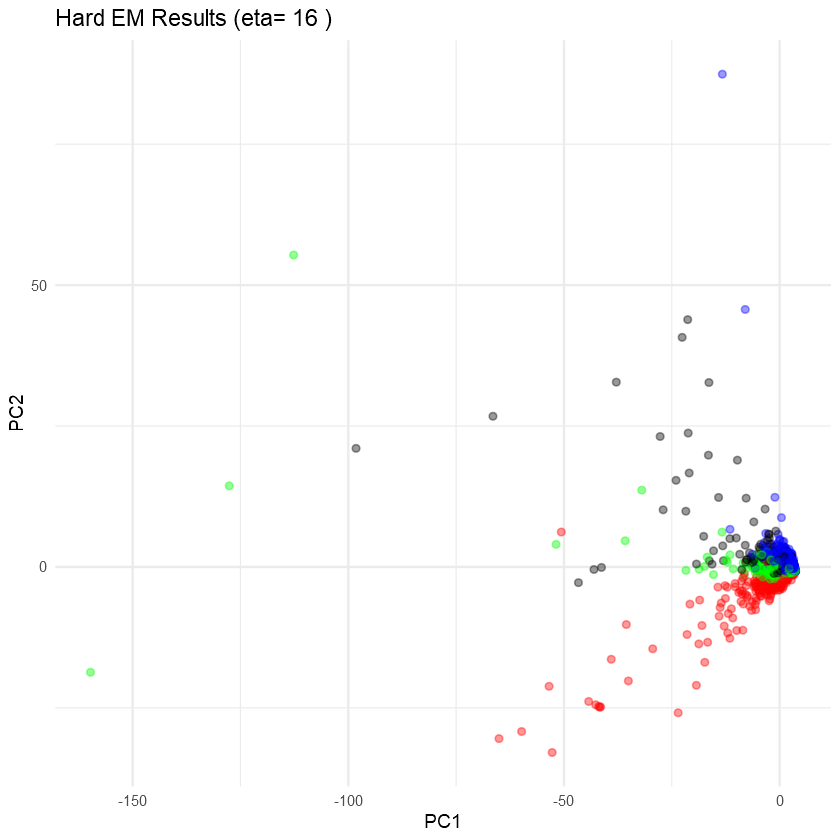

In [13]:
# plot PC1 against PC2
ggplot(data=as.data.frame(p.comp$x), aes(x=PC1, y=PC2)) + 
        geom_point(color=rgb(post), alpha=0.4) +
        ggtitle (paste('Hard EM Results (eta=', eta, ')')) + theme_minimal()
ggsave('Q1_2.jpg')